# Exploratory Data Analysis (EDA)
## Civil Comments – Toxic Comment Classification

Objective :
- Understand the structure of the Civil Comments dataset
- Analyze the distribution of labels (toxicity)
- Study comment length
- Identify class imbalances

This analysis is conducted **prior to any preprocessing**, in order to guide
data cleaning and modeling choices.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

plt.style.use("seaborn-v0_8")


d:\envs\advanced_env_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset loading

In [2]:
# Load Civil Comments dataset
dataset = load_dataset("thesofakillers/jigsaw-toxic-comment-classification-challenge")  #google/civil_comments

# train (80%) / validation(10%) / test(10%) split
train_test = dataset["train"].train_test_split(
    test_size=0.2,
    seed=42
)

valid_test = train_test["test"].train_test_split(
    test_size=0.5,
    seed=42
)

train_ds = train_test["train"]
valid_ds = valid_test["train"]
test_ds  = valid_test["test"]


# Convert to Pandas for easier manipulation
df_train = train_ds.to_pandas().rename(columns={"comment_text": "text"}).drop(columns=["id"])
df_valid = valid_ds.to_pandas().rename(columns={"comment_text": "text"}).drop(columns=["id"])
df_test  = test_ds.to_pandas().rename(columns={"comment_text": "text"}).drop(columns=["id"])


# Show shapes
print("Train size:", df_train.shape)
print("Validation size:", df_valid.shape)
print("Test size:", df_test.shape)

Train size: (127656, 7)
Validation size: (15957, 7)
Test size: (15958, 7)


The **Civil Comments** dataset is loaded using the HuggingFace `datasets` library,
we define the train set, validation set and test set as follow (80%, 10%, 10%)

Each observation corresponds to a user-generated comment, annotated along
multiple toxicity dimensions.


In [3]:
df_train.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Missing Champions \n\nThis article should have...,0,0,0,0,0,0
1,""":This article is essentially puffery, written...",0,0,0,0,0,0
2,"""\n""""Properly"""" is your POV. It's not reasona...",0,0,0,0,0,0
3,"""\n\nThis is the website, http://en.wikipedia....",0,0,0,0,0,0
4,"""==Notable Alumni==\n\nThe Venerable Shi Ming ...",0,0,0,0,0,0


### Toxicity dimensions (labels)

In [5]:
df_train.columns

Index(['text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [6]:
label_cols = [
    'toxic', 
    'severe_toxic', 
    'obscene', 
    'threat', 
    'insult',
    'identity_hate'
]

label_counts = df_train[label_cols].sum().sort_values(ascending=False)

label_counts


toxic            12276
obscene           6773
insult            6307
severe_toxic      1296
identity_hate     1137
threat             391
dtype: int64

The task addressed in this project is a **multilabel classification problem**:
a single comment can belong to multiple toxicity categories simultaneously.

The considered labels are:
- `toxic`: overall perceived toxicity,
- `severe_toxic`: severe toxicity,
- `obscene`: obscene content,
- `threat`: explicit threats,
- `insult`: insulting language,
- `identity_hate`: attacks targeting a protected group.



### Label distribution

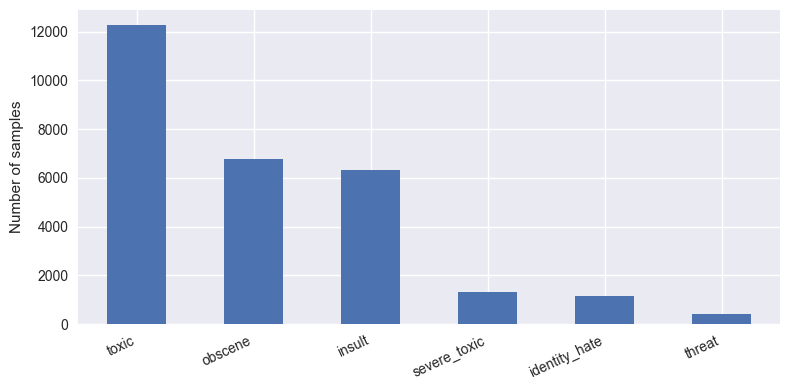

In [9]:
label_counts.plot(kind="bar", figsize=(8,4))
# plt.title("### Label distribution – Train set")
plt.ylabel("Number of samples")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()

plt.savefig("../reports/figures/label_distribution_train.png")
plt.show()


The bar plot above illustrates the distribution of toxicity dimensions within
the training set.

A **strong class imbalance** is clearly observed:
- `toxicity`, `obscene` and `insult` are relatively frequent,
- while `threat`, `identity_hate` and `severe_toxicity` are extremely rare.

This imbalance is a well-known characteristic of online content moderation
datasets and represents a major challenge for machine learning models.

These observations motivate:
- the use of appropriate evaluation metrics (e.g. macro F1-score),
- the possible application of class weighting strategies,
- and the choice of models robust to rare classes.


### Comment length analysis



Two complementary length measures are introduced:
- length in **characters**,
- length in **words**.

These features provide insight into the textual structure of the dataset,
revealing whether comments are predominantly short or long and whether a
long-tail distribution is present.

Understanding text length distributions is essential for:
- defining maximum sequence lengths,
- selecting suitable tokenization strategies,
- and anticipating the computational cost of downstream models.


In [10]:
df_train["length_chars"] = df_train["text"].str.len()
df_train["length_words"] = df_train["text"].str.split().apply(len)

df_train[["length_chars", "length_words"]].describe(percentiles=[0.5, 0.95])


,length_chars,length_words
count,127656.000000,127656.000000
mean,394.328516,67.301012
std,592.059148,99.428243
min,6.000000,1.000000
50%,205.000000,36.000000
95%,1359.000000,230.000000
max,5000.000000,1411.000000


### Statistical analysis of comment lengths

The descriptive statistics indicate that:
- most comments are relatively short,
- but a long tail of very long comments exists.

This behavior is consistent with findings reported in the literature, where
median comment lengths are typically on the order of a few dozen tokens, while
extreme values can reach several hundred tokens.

These results suggest that **sequence truncation** will be necessary during
model training to control complexity while preserving informative content.


### Length histogram 

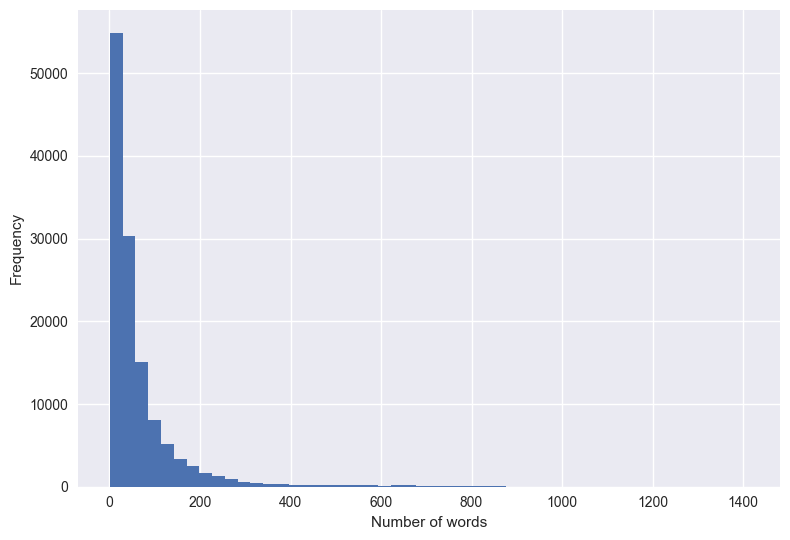

In [12]:
df_train["length_words"].hist(bins=50)
# plt.title("Distribution de la longueur des commentaires (en mots)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()

plt.savefig("../reports/figures/comment_length_words.png")
plt.show()


### Distribution of comment lengths

The histogram highlights a highly skewed distribution:
- a strong concentration of short comments,
- followed by a gradual decay toward larger lengths.

Such distributions are typical of user-generated online content.

This observation supports:
- the use of models optimized for short texts,
- and careful preprocessing choices to avoid unnecessarily inflating sequence
  length.


## Conclusion of the exploratory data analysis

This exploratory analysis highlights several key properties of the dataset:

- a strong **class imbalance**, especially for rare labels,
- **predominantly short comments** with a long-tail distribution,
- a **multilabel structure** with correlated toxicity dimensions.

These findings will directly inform subsequent methodological choices,
including:
- text preprocessing strategies,
- target definition and label handling,
- model selection and evaluation metrics.
